In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/drive/MyDrive/DataSet/Metro_Interstate_Traffic_Volume.csv")

print("Dataset loaded! Shape:", df.shape)
df.head()

Dataset loaded! Shape: (48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [4]:
df['date_time'] = pd.to_datetime(df['date_time'])

print("date_time converted to datetime!")
df.dtypes

date_time converted to datetime!


,0
holiday,object
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object
date_time,datetime64[ns]
traffic_volume,int64


Basic EDA

We'll look at:

Missing values

Descriptive statistics

Traffic distribution

Traffic over time (line plot)

In [5]:
df.isna().sum()

,0
holiday,48143
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0
traffic_volume,0


The holiday column is mostly empty
which matches the dataset description: it only contains values on holidays, and "No Holiday" for normal days.

We need to fill missing rows with "No Holiday" later.
This is normal.

In [6]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,2016-01-05 10:46:16.773711616,3259.818355
min,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000
25%,272.160000,0.000000,0.000000,1.000000,2014-02-06 11:45:00,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,2016-06-11 03:30:00,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,2017-08-11 06:00:00,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,2018-09-30 23:00:00,7280.000000
std,13.338232,44.789133,0.008168,39.015750,NaN,1986.860670


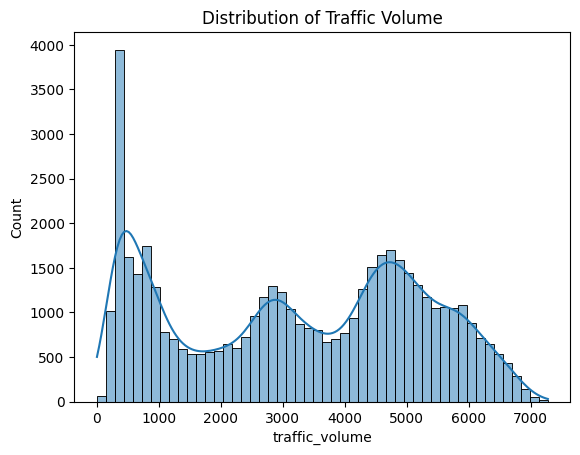

In [7]:
plt.figure()
sns.histplot(df['traffic_volume'], bins=50, kde=True)
plt.title("Distribution of Traffic Volume")
plt.show()

1.  Peak around 500–1000 cars/hour → night time (low traffic)
2.  Peak around 2500–3500 → mid-day traffic
3.  Peak around 4500–5500 → evening rush hour


4. Right tail up to 7000 → heavy traffic periods

---> This confirms: time-of-day effects are VERY strong.
We will extract hour, weekday, month, weekend, rush_hour features.

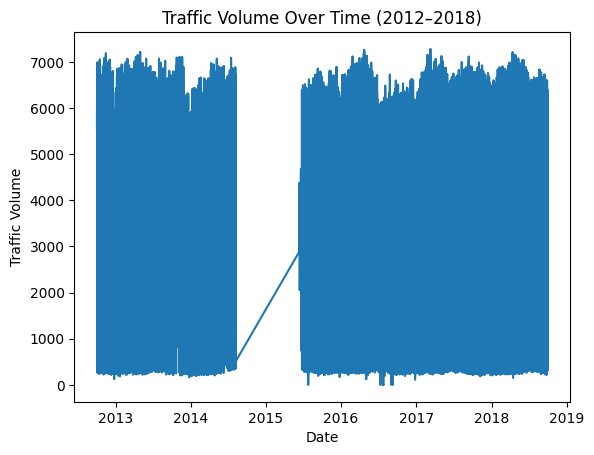

In [8]:

plt.figure()
plt.plot(df['date_time'], df['traffic_volume'])
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Over Time (2012–2018)")
plt.show()

.Large gap between 2014 → 2016
→ The dataset has missing months/years (normal for this dataset)


.Traffic is very noisy
→ normal because this is hourly data.


.Clear “block” structure for each year
→ each year has similar seasonal patterns.

We will need to carefully train/test split:

Train: 2012 → 2016

Validation: 2017

Test: 2018

In [9]:
#Extract Time Features
df['hour'] = df['date_time'].dt.hour
df['day'] = df['date_time'].dt.day
df['weekday'] = df['date_time'].dt.weekday   # Monday=0, Sunday=6
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

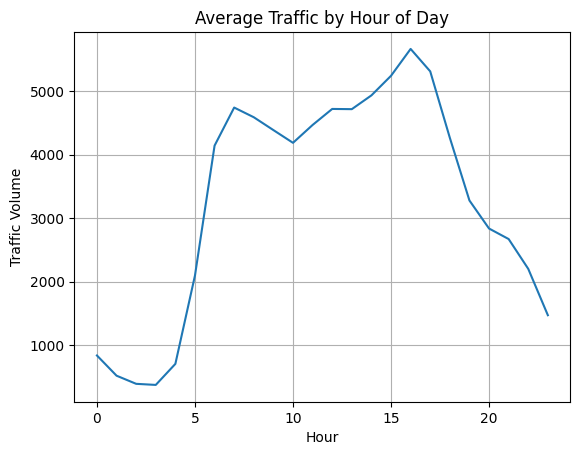

In [10]:
#Average traffic by hour
hourly_avg = df.groupby('hour')['traffic_volume'].mean()

plt.figure()
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average Traffic by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.show()


graph shows:

2–5 AM → extremely low traffic ✔️

6 AM → sharp rise ✔️

7–8 AM = morning rush hour

Stabilizes mid-day

4–6 PM = evening rush hour (peak at 17:00)

After 7 PM → traffic decreases

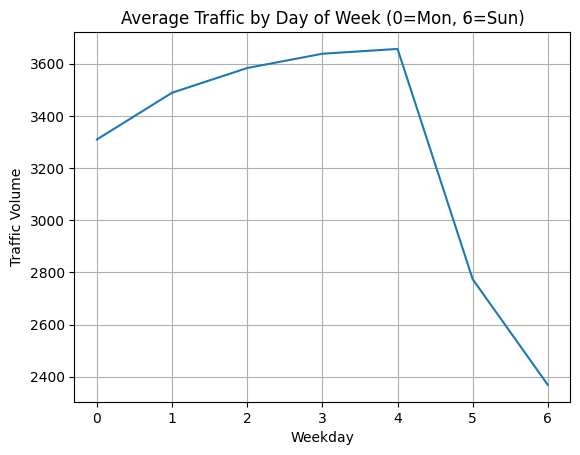

In [11]:
#Average traffic by day of week
weekday_avg = df.groupby('weekday')['traffic_volume'].mean()

plt.figure()
sns.lineplot(x=weekday_avg.index, y=weekday_avg.values)
plt.title("Average Traffic by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Weekday")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.show()


Mon → Tue → Wed → Thu → Fri → all have high traffic
Sat → drop
Sun → lowest

. Weekend = low traffic

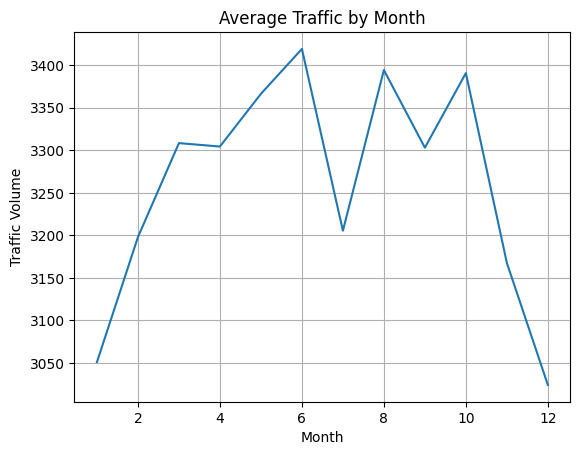

In [12]:
#Average traffic by month
monthly_avg = df.groupby('month')['traffic_volume'].mean()

plt.figure()
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title("Average Traffic by Month")
plt.xlabel("Month")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.show()


graph shows:

Low in January

Rises into spring

Peak around June

Drop in July (vacations?)

Rises again in August/October

Drop in winter (snow)

This is also typical:
Winter = dangerous roads → people stay home.
Summer = more movement.

In [13]:
#fix missing holidays
df['holiday'] = df['holiday'].fillna("No Holiday")
holiday_avg = df.groupby('holiday')['traffic_volume'].mean().sort_values()
holiday_avg


,traffic_volume
holiday,
Columbus Day,519.400000
Martin Luther King Jr Day,612.666667
State Fair,634.800000
Washingtons Birthday,635.200000
Veterans Day,691.400000
Christmas Day,827.500000
Thanksgiving Day,933.500000
Labor Day,1013.142857
Independence Day,1076.000000


Traffic on holidays is MUCH lower than normal days.

**Feature Engineering**

In [15]:
#Lag Features
df['lag_1'] = df['traffic_volume'].shift(1)
df['lag_24'] = df['traffic_volume'].shift(24)

# Drop the first 24 rows (they contain NaN)
df = df.dropna()


In [16]:
#Rolling Features
df['rolling_3h'] = df['traffic_volume'].rolling(window=3).mean()
df['rolling_6h'] = df['traffic_volume'].rolling(window=6).mean()
df['rolling_24h'] = df['traffic_volume'].rolling(window=24).mean()

df = df.dropna()

In [17]:
# Convert weather and holiday into categories
df['holiday'] = df['holiday'].fillna("No Holiday")
df['holiday'] = df['holiday'].astype('category')
df['weather_main'] = df['weather_main'].astype('category')

df = pd.get_dummies(df, columns=['holiday', 'weather_main'], drop_first=True)


In [18]:
df['rush_hour'] = df['hour'].isin([7,8,9,16,17,18]).astype(int)


In [19]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,hour,day,weekday,...,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,rush_hour
47,294.97,0.0,0.0,1,sky is clear,2012-10-04 12:00:00,5104,12,4,3,...,False,False,False,False,False,False,False,False,False,0
48,296.38,0.0,0.0,1,sky is clear,2012-10-04 13:00:00,5178,13,4,3,...,False,False,False,False,False,False,False,False,False,0
49,297.32,0.0,0.0,1,sky is clear,2012-10-04 14:00:00,5501,14,4,3,...,False,False,False,False,False,False,False,False,False,0
50,298.17,0.0,0.0,1,sky is clear,2012-10-04 15:00:00,5713,15,4,3,...,False,False,False,False,False,False,False,False,False,0
51,298.06,0.0,0.0,20,few clouds,2012-10-04 16:00:00,6292,16,4,3,...,False,False,False,False,False,False,False,False,False,1


In [20]:
df.shape

(48157, 40)

In [21]:
#Time-Series Split
train_df = df[df['year'] <= 2016]
val_df   = df[df['year'] == 2017]
test_df  = df[df['year'] == 2018]

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

Train: (29603, 40)
Validation: (10605, 40)
Test: (7949, 40)


In [22]:
# Drop columns that should not be used for training
cols_to_drop = ['traffic_volume', 'date_time', 'weather_description']

X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df['traffic_volume']

X_val = val_df.drop(columns=cols_to_drop)
y_val = val_df['traffic_volume']

X_test = test_df.drop(columns=cols_to_drop)
y_test = test_df['traffic_volume']

print("Final feature count:", X_train.shape[1])


Final feature count: 37


**MODELLING**

In [24]:
#Baseline Model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Baseline prediction: previous hour lag
y_pred_baseline = X_test['lag_1']

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print("Baseline MAE:", round(mae_baseline, 2))
print("Baseline RMSE:", round(rmse_baseline, 2))

Baseline MAE: 483.96
Baseline RMSE: 737.95


Traffic is very noisy, so the baseline is strong.

In [25]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("Model trained!")

Model trained!


In [26]:
# Predict
y_pred_rf = rf.predict(X_test)

# Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest MAE:", round(mae_rf, 2))
print("Random Forest RMSE:", round(rmse_rf, 2))


Random Forest MAE: 107.98
Random Forest RMSE: 163.91


RandomForest absolutely crushed the baseline model.
model is ~78% more accurate than baseline

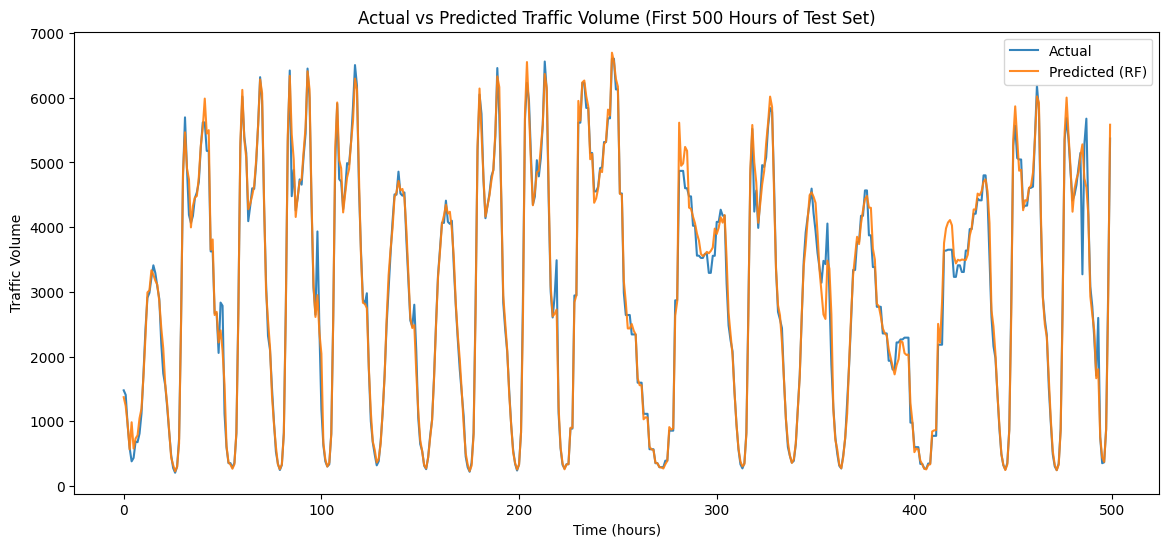

In [27]:
# Plot Actual vs Predicted
plt.figure(figsize=(14,6))
plt.plot(y_test.values[:500], label="Actual", alpha=0.9)
plt.plot(y_pred_rf[:500], label="Predicted (RF)", alpha=0.9)
plt.title("Actual vs Predicted Traffic Volume (First 500 Hours of Test Set)")
plt.xlabel("Time (hours)")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()

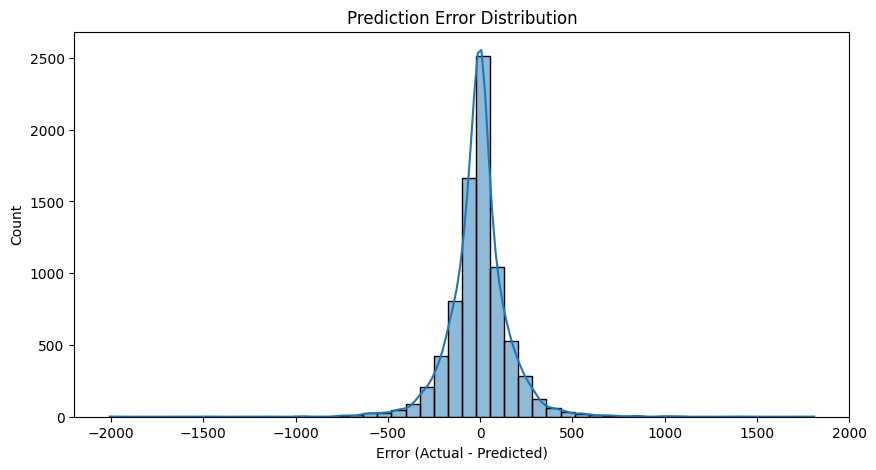

In [28]:
#Error Distribution
errors = y_test - y_pred_rf

plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")
plt.show()

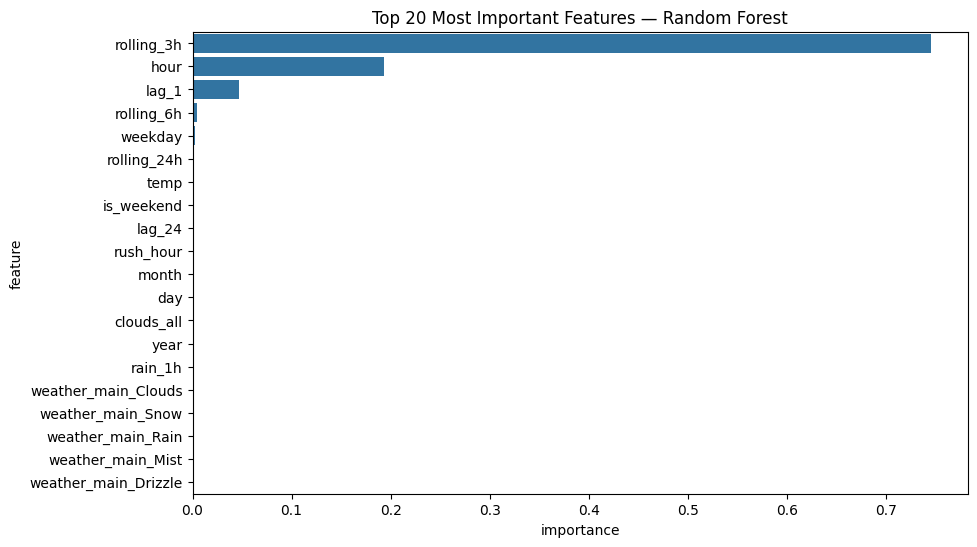

In [29]:
# Feature Importance

importances = rf.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({"feature": features, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Top 20 Most Important Features — Random Forest")
plt.show()